In [6]:
import numpy as np
import matplotlib.pyplot as plt
import itertools, tqdm, UQ, projection_correction
from scipy.linalg import solve_triangular
from scipy.sparse.linalg import spsolve

%matplotlib inline

In [7]:
Jacobi = lambda x, rhs, A, D, omega=2/3: x + omega*(rhs - A @ x)/D
GS = lambda x, rhs, A, low_A, solver: x + solver(rhs - A @ x, low_A)
Richardson = lambda x, rhs, A, omega=1/10: x + omega*(rhs - A @ x)

# Experiments with UQ

In [8]:
Cos = []
Trace_error = []
Error = []
Residual = []
N, N_it, M, N_samples = 100, 101, 10, 100
problem = lambda size, scale=0.01: UQ.random_matrix_expon(size, scale=scale)


for i in tqdm.tqdm(range(N_samples)):
  # Random matrix
  A, b, x_exact = problem(N)

  # # # Gauss-Seidel
  # Lower = np.triu(A)
  # solver = lambda rhs, low_A=Lower: solve_triangular(low_A, rhs)
  # L = lambda x, rhs, A=A, low_A=Lower, solver=solver: GS(x, rhs, A, low_A, solver)

  # # Jacobi
  # D = np.diag(A).reshape(-1, 1)
  # B = A/D
  # spectrum = np.linalg.eigvals(B)
  # omega_opt = 2/(max(spectrum) + min(spectrum))
  # L = lambda x, rhs, A=A, D=D, omega=omega_opt: Jacobi(x, rhs, A, D, omega=omega)

  # # Richardson
  spectrum = np.linalg.eigvals(A)
  omega_opt = 2/(max(spectrum) + min(spectrum))
  L = lambda x, rhs, A=A: Richardson(x, rhs, A, omega=omega_opt)

  #statistics, results = UQ.residual_UQ(A, np.zeros_like(b), L, 13, M, np.zeros_like(b), scale=None, start='random')
  statistics, results = UQ.random_static_UQ(A, np.zeros_like(b), L, 3, M, np.zeros_like(b), scale=None, start='random')
  scale = 2*statistics[0][-1]/statistics[3][-1]

  #statistics, results = UQ.residual_UQ(A, b, L, N_it, M, x_exact, scale=scale)
  statistics, results = UQ.random_static_UQ(A, b, L, N_it, M, x_exact, scale=scale)
  Cos.append(statistics[2][1:])
  Trace_error.append(statistics[0][1:]/statistics[3][1:])
  Error.append(statistics[0][1:])
  Residual.append(statistics[1][1:])

Cos = np.array(Cos)
Trace_error = np.array(Trace_error)
Error = np.array(Error)
Residual = np.array(Residual)

100%|██████████| 100/100 [00:09<00:00, 10.20it/s]


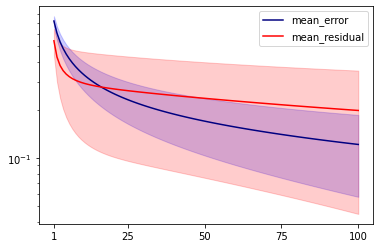

In [9]:
var_error = np.sqrt(np.var(Error, axis=0))
mean_error = np.mean(Error, axis=0)
var_residual = np.sqrt(np.var(Residual, axis=0))
mean_residual = np.mean(Residual, axis=0)
iteration = np.arange(1, len(mean_error)+1)
plt.yscale('log')
plt.plot(iteration, mean_error, label='mean_error', color='navy')
plt.fill_between(iteration, mean_error-var_error, mean_error+var_error, alpha=0.2, color='blue')
plt.plot(iteration, mean_residual, label='mean_residual', color='red')
plt.fill_between(iteration, mean_residual-var_residual, mean_residual+var_residual, alpha=0.2, color='red')
plt.xticks(np.linspace(1, N_it-1, 5, dtype=int))
plt.legend();

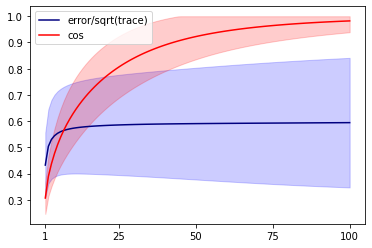

In [10]:
fig, ax = plt.subplots()
var_trace_error = np.sqrt(np.var(Trace_error, axis=0))
mean_trace_error = np.mean(Trace_error, axis=0)
iteration = np.arange(1, len(mean_trace_error)+1)
plt.plot(iteration, mean_trace_error, label='error/sqrt(trace)', color='navy')
plt.fill_between(iteration, (mean_trace_error-var_trace_error)*((mean_trace_error-var_trace_error)>0), mean_trace_error+var_trace_error, alpha=0.2, color='blue')
var_cos = np.sqrt(np.var(Cos, axis=0))
mean_cos = np.mean(Cos, axis=0)
iteration = np.arange(1, len(mean_cos)+1)
plt.plot(iteration, mean_cos, label='cos', color='red')
plt.fill_between(iteration, mean_cos-var_cos,  (mean_cos+var_cos)*((mean_cos+var_cos)<1) + ((mean_cos+var_cos)>=1), alpha=0.2, color='red')
plt.xticks(np.linspace(1, N_it-1, 5, dtype=int))
plt.legend();

## UQ figures

In [13]:
N, N_it, M, N_samples = 100, 101, 10, 100
Methods = ['Richardson', 'Jacobi', 'Gauss-Seidel']
UQ_ = [UQ.residual_UQ, UQ.random_static_UQ]
Scales = [0.01, 1, 100]
Results = {}

uq = UQ.residual_UQ
for method in Methods:
  for sc in Scales:
    Cos = []
    Trace_error = []
    problem = lambda size, scale=sc: UQ.random_matrix_expon(size, scale=scale)

    for i in tqdm.tqdm(range(N_samples)):
      A, b, x_exact = problem(N)

      if method == 'Gauss-Seidel':
        Lower = np.triu(A)
        solver = lambda rhs, low_A=Lower: solve_triangular(low_A, rhs)
        L = lambda x, rhs, A=A, low_A=Lower, solver=solver: GS(x, rhs, A, low_A, solver)

      if method == 'Jacobi':
        D = np.diag(A).reshape(-1, 1)
        B = A/D
        spectrum = np.linalg.eigvals(B)
        omega_opt = 2/(max(spectrum) + min(spectrum))
        L = lambda x, rhs, A=A, D=D, omega=omega_opt: Jacobi(x, rhs, A, D, omega=omega)

      if method == 'Richardson':
        spectrum = np.linalg.eigvals(A)
        omega_opt = 2/(max(spectrum) + min(spectrum))
        L = lambda x, rhs, A=A: Richardson(x, rhs, A, omega=omega_opt)

      statistics, results = uq(A, np.zeros_like(b), L, 3, M, np.zeros_like(b), scale=None, start='random')
      scale = 2*statistics[0][-1]/statistics[3][-1]

      statistics, results = uq(A, b, L, N_it, M, x_exact, scale=scale)
      Cos.append(statistics[2][1:])
      Trace_error.append(statistics[0][1:]/statistics[3][1:])

    Cos = np.array(Cos)
    Trace_error = np.array(Trace_error)

    var_trace_error = np.sqrt(np.var(Trace_error, axis=0))
    mean_trace_error = np.mean(Trace_error, axis=0)

    var_cos = np.sqrt(np.var(Cos, axis=0))
    mean_cos = np.mean(Cos, axis=0)
    Results[method+' '+str(sc)] = [mean_trace_error, var_trace_error, mean_cos, var_cos]

100%|██████████| 100/100 [00:11<00:00,  8.65it/s]


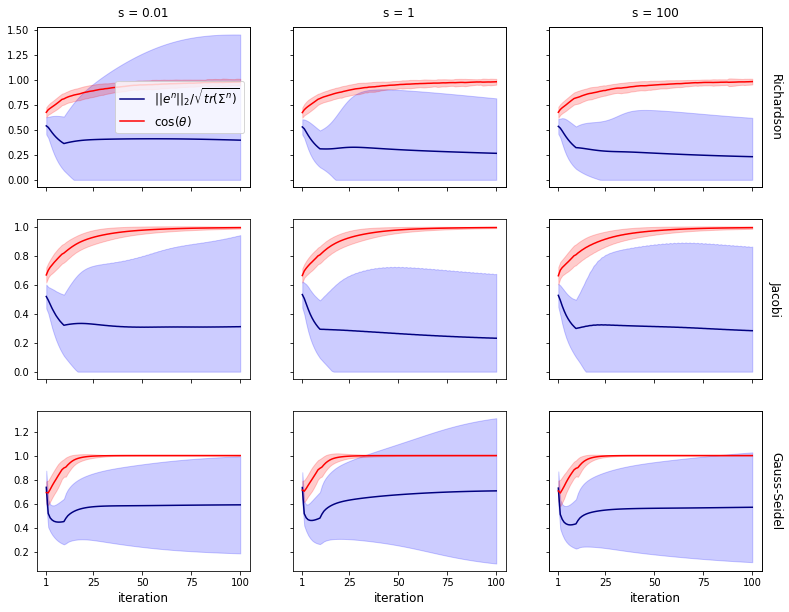

In [14]:
iteration = np.arange(1, len(mean_cos)+1)
fig, ax = plt.subplots(3, 3, figsize=(13, 10), sharex='col', sharey='row')

for row, method in enumerate(Methods):
  for column, scale in enumerate(Scales):
    ax[row, column].plot(iteration, Results[method+' '+str(scale)][0], label=r'$\left\||e^{n}\right\||_2/\sqrt{tr(\Sigma^{n})}$', color='navy')
    ax[row, column].plot(iteration, Results[method+' '+str(scale)][2], label=r'$\cos(\theta)$', color='red')
    ax[row, column].fill_between(iteration, (Results[method+' '+str(scale)][0]-Results[method+' '+str(scale)][1])*((Results[method+' '+str(scale)][0]-Results[method+' '+str(scale)][1])>0), Results[method+' '+str(scale)][0]+Results[method+' '+str(scale)][1], alpha=0.2, color='blue')
    ax[row, column].fill_between(iteration, (Results[method+' '+str(scale)][2]-Results[method+' '+str(scale)][3])*((Results[method+' '+str(scale)][2]-Results[method+' '+str(scale)][3])>0), Results[method+' '+str(scale)][2]+Results[method+' '+str(scale)][3], alpha=0.2, color='red')
    ax[row, column].set_xticks(np.linspace(1, N_it-1, 5, dtype=int))

ax[0, 0].legend(loc=5, fontsize='large')
for i in range(3):
  ax[2, i].set_xlabel('iteration', fontsize='large')

for row, method in enumerate(Methods):
  ax_y = ax[row, 2].twinx()
  ax_y.set_yticks([])
  ax_y.set_ylabel(method, fontsize='large', labelpad=20, rotation=-90)

for column, scale in enumerate(Scales):
  ax_y = ax[0, column].twiny()
  ax_y.set_xticks([])
  ax_y.set_xlabel(r's =' + ' ' + str(scale), fontsize='large', labelpad=10)

#plt.savefig('UQ_residual.pdf', format='pdf', bbox_inches='tight');

# Experiments with projections

In [4]:
N, N_it, M, N_samples, N_correction = 100, 501, 10, 100, 20
Scales = [0.01, 1, 100]
UQ_ = [projection_correction.corrected_residual_UQ, UQ.residual_UQ]
UQ_names = ['Gauss-Seidel + projection', 'Gauss-Seidel']
Results = {}


for uq, name in zip(UQ_, UQ_names):
  for sc in Scales:
    Error = []
    Residual = []
    problem = lambda size, scale=sc: UQ.random_matrix_expon(size, scale=scale)
    for i in tqdm.tqdm(range(N_samples)):
      A, b, x_exact = problem(N)

      Lower = np.triu(A)
      solver = lambda rhs, low_A=Lower: solve_triangular(low_A, rhs)
      L = lambda x, rhs, A=A, low_A=Lower, solver=solver: GS(x, rhs, A, low_A, solver)

      statistics, results = uq(A, np.zeros_like(b), L, 13, M, np.zeros_like(b), scale=None, start='random')
      scale = 2*statistics[0][-1]/statistics[3][-1]

      statistics, results = uq(A, b, L, N_it, M, x_exact, scale=scale)
      Error.append(statistics[0][1:])
      Residual.append(statistics[1][1:])

    Error = np.array(Error)
    Residual = np.array(Residual)
    var_error = np.sqrt(np.var(Error, axis=0))
    mean_error = np.mean(Error, axis=0)
    var_residual = np.sqrt(np.var(Residual, axis=0))
    mean_residual = np.mean(Residual, axis=0)
    Results[name+' '+str(sc)] = [mean_error, var_error, mean_residual, var_residual]

100%|██████████| 100/100 [00:50<00:00,  1.98it/s]


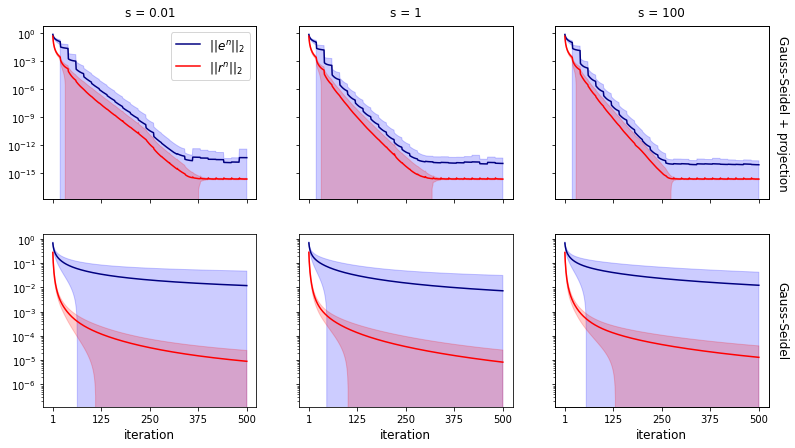

In [5]:
iteration = np.arange(1, len(mean_error)+1)
fig, ax = plt.subplots(2, 3, figsize=(13, 7), sharex='col', sharey='row')

for row, method in enumerate(UQ_names):
  for column, scale in enumerate(Scales):
    ax[row, column].plot(iteration, Results[method+' '+str(scale)][0], label=r'$\left\||e^{n}\right\||_2$', color='navy')
    ax[row, column].plot(iteration, Results[method+' '+str(scale)][2], label=r'$\left\||r^{n}\right\||_2$', color='red')
    ax[row, column].fill_between(iteration, (Results[method+' '+str(scale)][0]-Results[method+' '+str(scale)][1])*((Results[method+' '+str(scale)][0]-Results[method+' '+str(scale)][1])>0), Results[method+' '+str(scale)][0]+Results[method+' '+str(scale)][1], alpha=0.2, color='blue')
    ax[row, column].fill_between(iteration, (Results[method+' '+str(scale)][2]-Results[method+' '+str(scale)][3])*((Results[method+' '+str(scale)][2]-Results[method+' '+str(scale)][3])>0), Results[method+' '+str(scale)][2]+Results[method+' '+str(scale)][3], alpha=0.2, color='red')
    ax[row, column].set_xticks(np.linspace(1, N_it-1, 5, dtype=int))
    ax[row, column].set_yscale('log')

ax[0, 0].legend(loc='upper right', fontsize='large')
for i in range(3):
  ax[1, i].set_xlabel('iteration', fontsize='large')

for row, method in enumerate(UQ_names):
  ax_y = ax[row, 2].twinx()
  ax_y.set_yticks([])
  ax_y.set_ylabel(method, fontsize='large', labelpad=20, rotation=-90)

for column, scale in enumerate(Scales):
  ax_y = ax[0, column].twiny()
  ax_y.set_xticks([])
  ax_y.set_xlabel(r's =' + ' ' + str(scale), fontsize='large', labelpad=10)

#plt.savefig('UQ_speedup.pdf', format='pdf', bbox_inches='tight');